Import the necessary modules and StackOverflow csv files for 2019.

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('./2019/survey_results_public.csv')
schema = pd.read_csv('./2019/survey_results_schema.csv')
df.shape

(88883, 85)

A quick view of the survey results helps get a flavor for the underlying data:

In [2]:
df.head()

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,...,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,28.0,Man,No,Straight / Heterosexual,NaN,Yes,Appropriate in length,Neither easy nor difficult
3,4,I am a developer by profession,No,Never,The quality of OSS and closed source software ...,Employed full-time,United States,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,22.0,Man,No,Straight / Heterosexual,White or of European descent,No,Appropriate in length,Easy
4,5,I am a developer by profession,Yes,Once a month or more often,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,Ukraine,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,30.0,Man,No,Straight / Heterosexual,White or of European descent;Multiracial,No,Appropriate in length,Easy


A quick view of the survey schema allows a peak into how the data is structured:

In [3]:
schema.head()

,Column,QuestionText
0,Respondent,Randomized respondent ID number (not in order ...
1,MainBranch,Which of the following options best describes ...
2,Hobbyist,Do you code as a hobby?
3,OpenSourcer,How often do you contribute to open source?
4,OpenSource,How do you feel about the quality of open sour...


Let's have a look at the DevType question we wish to drill into to find respondants that work in Data Science:

In [4]:
list(schema[schema['Column'] == 'DevType']['QuestionText'])[0]

'Which of the following describe you? Please select all that apply.'

We want to create a few functions that will be utilized going forward.  They allow us to count and/or display various data pulled from the survey.

In [5]:
# Method taken from Udacity Data Science course: https://www.udacity.com/course/data-scientist-nanodegree--nd025
def total_count(df, col1, col2, look_for, delim=';'):
    """
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col1]
    delim - string delimiter value to break up the string by

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    """
    new_df = defaultdict(int)
    # loop through list of ed types
    for val in look_for:
        # loop through rows
        for idx in range(df.shape[0]):
            # if the type is in the row add 1
            if val in df[col1][idx].split(delim):
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

In [6]:
# Inspired by Udacity Data Science course: https://www.udacity.com/course/data-scientist-nanodegree--nd025
def clean_and_plot(df, possible_vals, col='', title='', plot=True):
    '''
    INPUT
        df - a dataframe holding the column in the col parameter
        possible_vals - list of possible values to search for
        col - The column to search
        title - string the title of your plot
        plot - bool providing whether or not you want a plot back

    OUTPUT
        new_df - a dataframe with the count of how many individuals
        Displays a plot of pretty things related to the CousinEducation column.
    '''
    new_df = df[col].value_counts().reset_index()
    new_df.rename(columns={'index': 'method', col: 'count'}, inplace=True)
    new_df = total_count(new_df, 'method', 'count', possible_vals)

    new_df.set_index('method', inplace=True)
    if plot:
        (new_df / new_df.sum()).plot(kind='bar', legend=None)
        plt.title(title)
        plt.show()
    new_df = new_df / new_df.sum()
    return new_df


In [7]:
# Looks at all the values in a given column and compiles a set of unique values broken up
# by a given delimeter
def count_lists(df, col, delim=';'):
    """
    INPUT:
    df - the pandas dataframe you want to search
    col - the column name you want to look through
    delim - string delimiter value to break up the string by

    OUTPUT:
   index_set = set of items found from the lists
    """
    my_list = []

    df = df[col].value_counts()
    for index, value in df.items():
        my_list += index.split(delim)
    index_set = list(set(my_list))
    return index_set

Let's take a look at a breakdown of the number of people that classify themselves doing particular jobs.  Keep in mind that when answering the question someone can pick multiple roles:

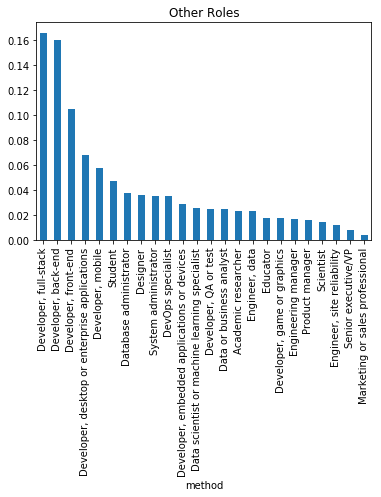

,count
method,
"Developer, full-stack",0.165649
"Developer, back-end",0.159540
"Developer, front-end",0.104551
"Developer, desktop or enterprise applications",0.067935
"Developer, mobile",0.057664
Student,0.046769
Database administrator,0.037350
Designer,0.036024
System administrator,0.035031


In [8]:
list_values = count_lists(df, col='DevType', delim=';')
clean_and_plot(df, list_values, col='DevType', title='Other Roles')

Let's focus on the rows for DevTypes that consider their job or part of their job a "Data scientist or machine learning specialist".  This will leave us with 6460 rows to work with. We will also remove the null values prior to this:

In [9]:
df = df[df.DevType.notnull()]
df_non_ds = df[df['DevType'].str.contains('Data scientist or machine learning specialist') == False]
df_ds = df[df['DevType'].str.contains('Data scientist or machine learning specialist')]
print('Number of rows of type DS/ML: {}\nNumber of rows in non-DS/ML occupations: {}'.
      format(df_ds.shape[0], df_non_ds.shape[0]))

Number of rows of type DS/ML: 6460
Number of rows in non-DS/ML occupations: 74875


We want to see what the education levels are for those in the DS/ML field(s) and compare those with non DS/ML occupations:

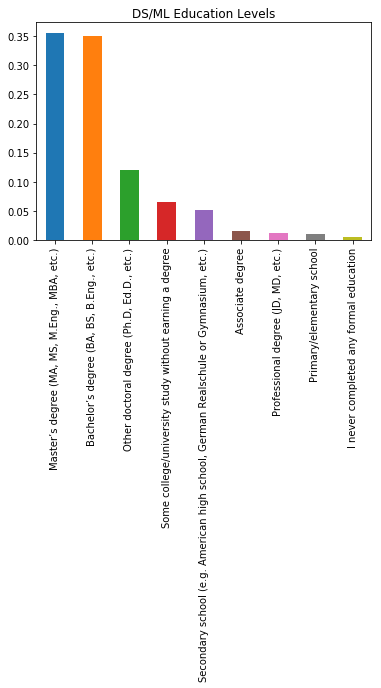

In [10]:
chart_values = df_ds.EdLevel.value_counts()
(chart_values/df_ds.shape[0]).plot(kind="bar");
plt.title("DS/ML Education Levels");

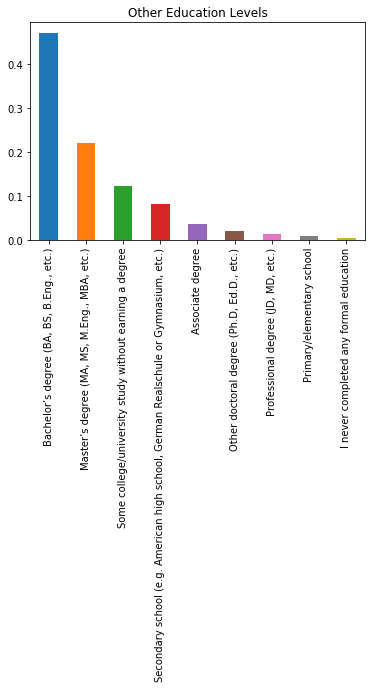

In [11]:
chart_values = df_non_ds.EdLevel.value_counts()
(chart_values/df_non_ds.shape[0]).plot(kind="bar");
plt.title("Other Education Levels");

Let's also have a look to see what the majors were for those in the DS/ML field(s) and compare those with non DS/ML occupation:

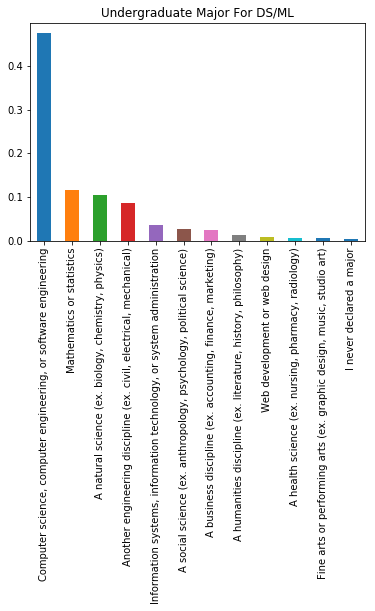

In [12]:
chart_values = df_ds.UndergradMajor.value_counts() 
(chart_values/df_ds.shape[0]).plot(kind="bar");
plt.title("Undergraduate Major For DS/ML");

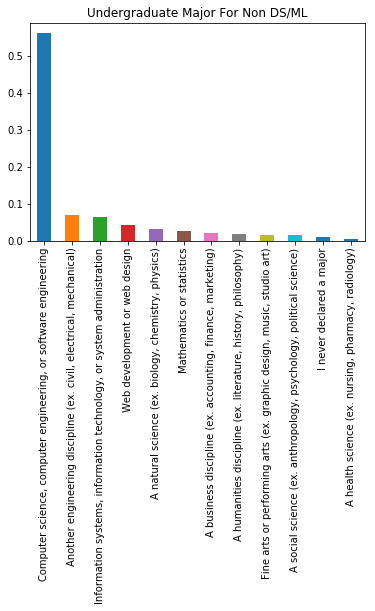

In [13]:
chart_values = df_non_ds.UndergradMajor.value_counts() 
(chart_values/df_non_ds.shape[0]).plot(kind="bar");
plt.title("Undergraduate Major For Non DS/ML");

Out of curiosity, lets take a look at the average compensation (converted to USD) and average hours worked per week for the DS/ML field(s) and compare those with non DS/ML occupation:

In [14]:
comp = df_ds.ConvertedComp.mean()
hours = df_ds.WorkWeekHrs.mean()

print("DS/ML Compensation: ${:,.2f} and Hours: {}".format(comp, round(hours,1)))

DS/ML Compensation: $142,191.27 and Hours: 42.5


In [15]:
comp = df_non_ds.ConvertedComp.mean()
hours = df_non_ds.WorkWeekHrs.mean()

print("Non DS/ML Compensation: ${:,.2f} and Hours: {}".format(comp, round(hours,1)))

Non DS/ML Compensation: $125,578.58 and Hours: 42.1


Let's take a look at the amount of time people work remotely in the DS/ML field(s) and compare those with non DS/ML occupation:

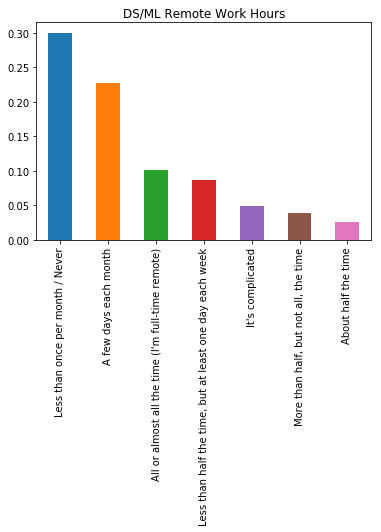

In [16]:
chart_values = df_ds.WorkRemote.value_counts() 
(chart_values/df_ds.shape[0]).plot(kind="bar");
plt.title("DS/ML Remote Work Hours");

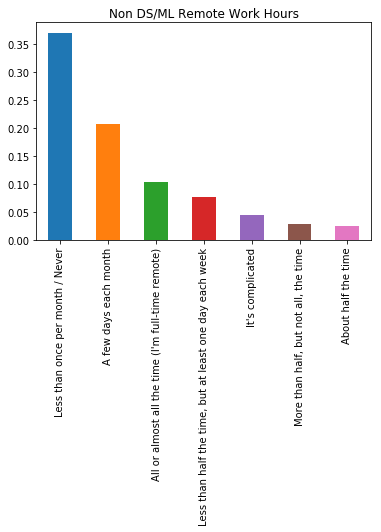

In [17]:
chart_values = df_non_ds.WorkRemote.value_counts() 
(chart_values/df_non_ds.shape[0]).plot(kind="bar");
plt.title("Non DS/ML Remote Work Hours");

What are the ages grouped in 10 bins for DS/ML field(s) and compare those with non DS/ML occupation?

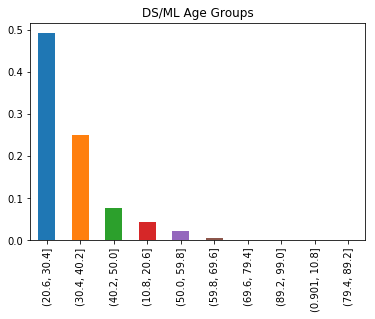

In [18]:
chart_values = df_ds.Age.value_counts(bins=10) 
(chart_values/df_ds.shape[0]).plot(kind="bar");
plt.title("DS/ML Age Groups");

In [19]:
df_ds.Age.mean() # What is the average age for people in the DS/ML field(s)

30.49633871247614

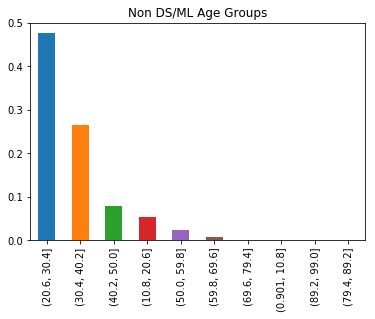

In [20]:
chart_values = df_non_ds.Age.value_counts(bins=10) 
(chart_values/df_non_ds.shape[0]).plot(kind="bar");
plt.title("Non DS/ML Age Groups");

In [21]:
df_non_ds.Age.mean() # What is the average age for people in the Non DS/ML field(s)

30.717124863573346

Let's take a look at the Gender breakdown in the DS/ML field(s) and compare those with non DS/ML occupation:

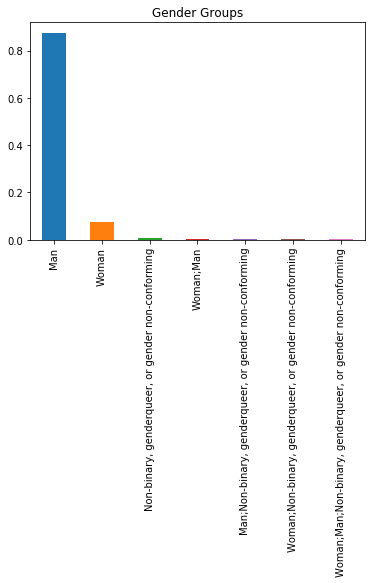

In [22]:
chart_values = df_ds.Gender.value_counts() 
(chart_values/df_ds.shape[0]).plot(kind="bar");
plt.title("Gender Groups");

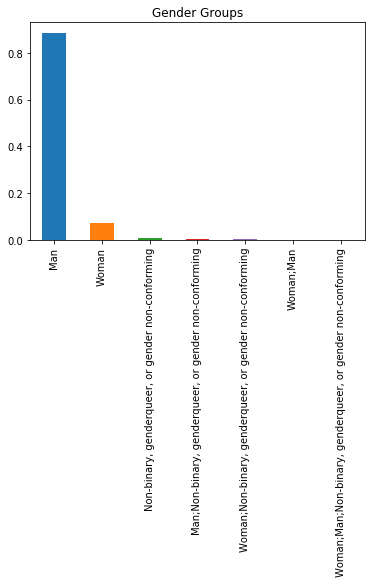

In [23]:
chart_values = df_non_ds.Gender.value_counts() 
(chart_values/df_non_ds.shape[0]).plot(kind="bar");
plt.title("Gender Groups");

Let's take a look at the programming languages people in the DS/ML field(s) and compare those with non DS/ML occupation:

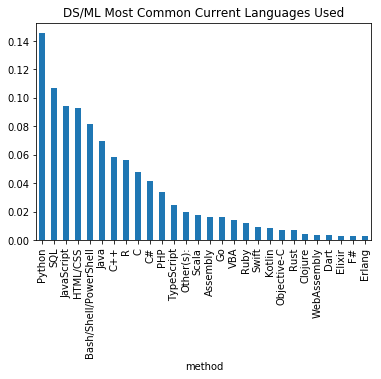

In [24]:
list_values = count_lists(df_ds, col='LanguageWorkedWith', delim=';')
props_df = clean_and_plot(df_ds, list_values, col='LanguageWorkedWith', title='DS/ML Most Common Current Languages Used')

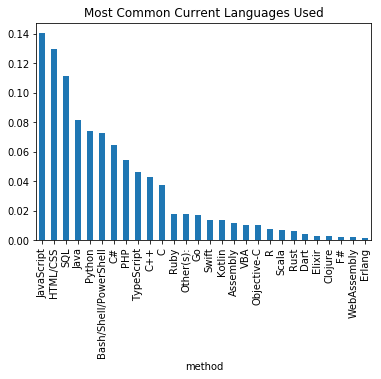

In [25]:
list_values = count_lists(df_non_ds, col='LanguageWorkedWith', delim=';')
props_df = clean_and_plot(df_non_ds, list_values, col='LanguageWorkedWith', title='Most Common Current Languages Used')

Let's take a look at the programming languages people in the DS/ML field(s) want to learn over the next year and compare those with non DS/ML occupation:

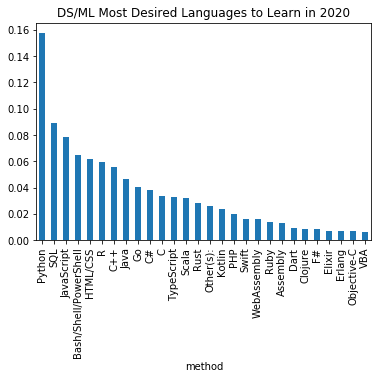

In [26]:
list_values = count_lists(df_ds, col='LanguageDesireNextYear', delim=';')
props_df = clean_and_plot(df_ds, list_values, col='LanguageDesireNextYear', title='DS/ML Most Desired Languages to Learn in 2020')

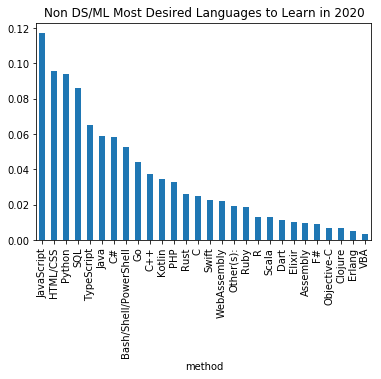

In [27]:
list_values = count_lists(df_non_ds, col='LanguageDesireNextYear', delim=';')
props_df = clean_and_plot(df_non_ds, list_values, col='LanguageDesireNextYear', title='Non DS/ML Most Desired Languages to Learn in 2020')

Let's take a look at the most common DB systems people in the DS/ML field(s) work with and compare those with non DS/ML occupation:

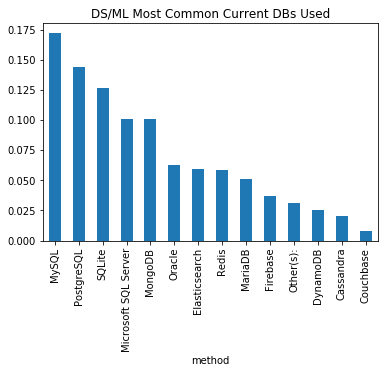

In [28]:
list_values = count_lists(df_ds, col='DatabaseWorkedWith', delim=';')
props_df = clean_and_plot(df_ds, list_values, col='DatabaseWorkedWith', title='DS/ML Most Common Current DBs Used')

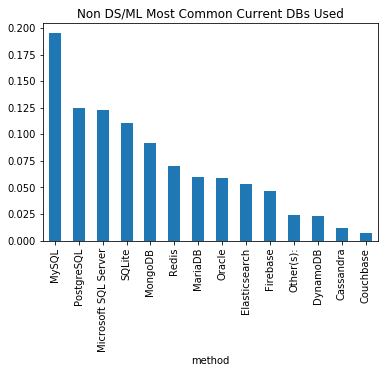

In [29]:
list_values = count_lists(df_non_ds, col='DatabaseWorkedWith', delim=';')
props_df = clean_and_plot(df_non_ds, list_values, col='DatabaseWorkedWith', title='Non DS/ML Most Common Current DBs Used')

Let's take a look at the most common DB systems people in the DS/ML field(s) want to work with and compare those with non DS/ML occupation:

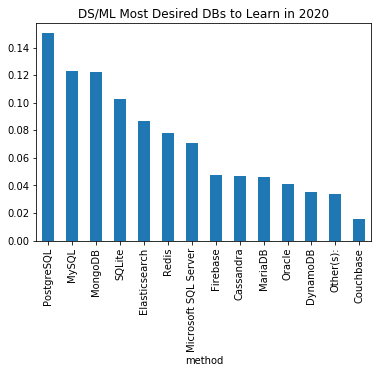

In [30]:
list_values = count_lists(df_ds, col='DatabaseDesireNextYear', delim=';')
props_df = clean_and_plot(df_ds, list_values, col='DatabaseDesireNextYear', title='DS/ML Most Desired DBs to Learn in 2020')

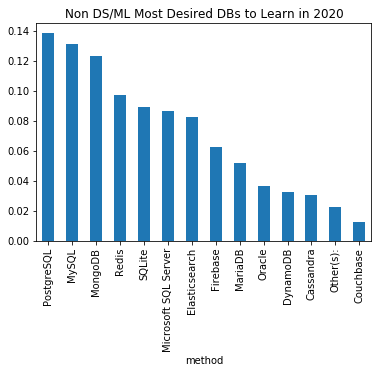

In [31]:
list_values = count_lists(df_non_ds, col='DatabaseDesireNextYear', delim=';')
props_df = clean_and_plot(df_non_ds, list_values, col='DatabaseDesireNextYear', title='Non DS/ML Most Desired DBs to Learn in 2020')

Let's take a look at the primary OS people in the DS/ML field(s)  work with and compare those with non DS/ML occupation:

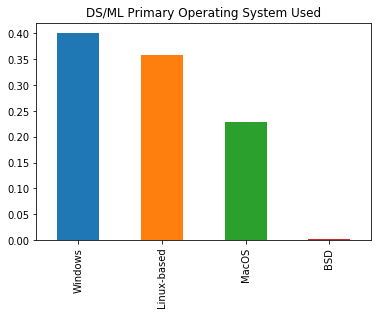

In [32]:
chart_values = df_ds.OpSys.value_counts() 
(chart_values/df_ds.shape[0]).plot(kind="bar");
plt.title("DS/ML Primary Operating System Used");

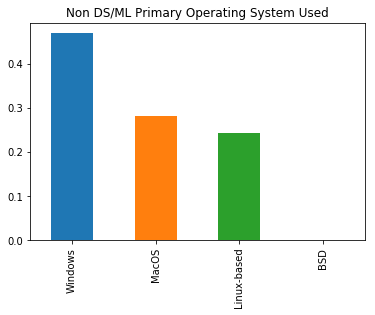

In [33]:
chart_values = df_non_ds.OpSys.value_counts() 
(chart_values/df_non_ds.shape[0]).plot(kind="bar");
plt.title("Non DS/ML Primary Operating System Used");

Let's take a look at the primary dev environments people in the DS/ML field(s) work with and compare those with non DS/ML occupation:

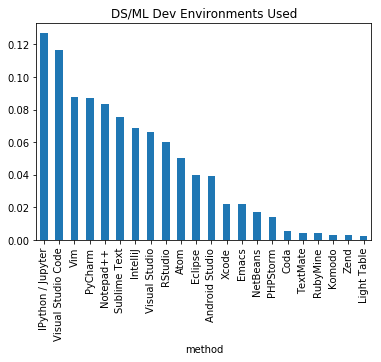

In [34]:
list_values = count_lists(df_ds, col='DevEnviron', delim=';')
props_df = clean_and_plot(df_ds, list_values, col='DevEnviron', title='DS/ML Dev Environments Used')

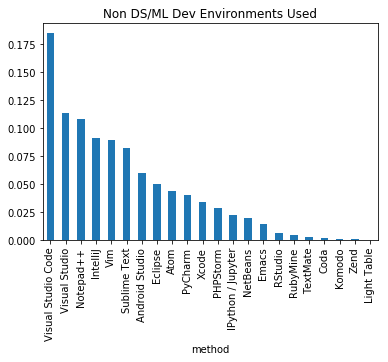

In [35]:
list_values = count_lists(df_non_ds, col='DevEnviron', delim=';')
props_df = clean_and_plot(df_non_ds, list_values, col='DevEnviron', title='Non DS/ML Dev Environments Used')

Let's take a look at the level of self reported competence in the DS/ML field(s) and compare those with non DS/ML occupation:

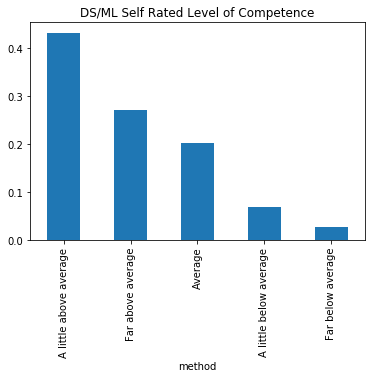

In [36]:
list_values = count_lists(df_ds, col='ImpSyn', delim=';')
props_df = clean_and_plot(df_ds, list_values, col='ImpSyn', title='DS/ML Self Rated Level of Competence')

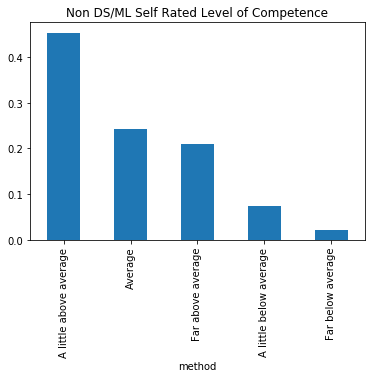

In [ ]:
list_values = count_lists(df_non_ds, col='ImpSyn', delim=';')
props_df = clean_and_plot(df_non_ds, list_values, col='ImpSyn', title='Non DS/ML Self Rated Level of Competence')

Finally, let's take a look at the other job roles people who reported they have a DS/ML role have:

In [ ]:
list_values = count_lists(df_ds, col='DevType', delim=';')
list_values.remove('Data scientist or machine learning specialist')
props_df = clean_and_plot(df_ds, list_values, col='DevType', title='DS/ML Other Roles')

In [ ]:
list_values = count_lists(df_non_ds, col='DevType', delim=';')
props_df = clean_and_plot(df_non_ds, list_values, col='DevType', title='Non DS/ML Other Roles')